## Benchmark the performance of the LogRegCCD 

Comparing to the sklearn LogisticRegression model as a baseline.

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)


from sklearn.linear_model import LogisticRegression  # noqa: E402
from sklearn.model_selection import train_test_split  # noqa: E402
from sklearn.metrics import balanced_accuracy_score, f1_score  # noqa: E402

from algorithm.ccd import LogRegCCD  # noqa: E402
from datasets.synthetic import generate_synthetic_data  # noqa: E402
from datasets.real import get_dataset_1, get_dataset_2  # noqa: E402

In [2]:
TRAIN_SIZE = 0.6
VAL_SIZE = 0.2
TEST_SIZE = 0.2
assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == 1.0

In [3]:
synthetic_x, synthetic_y = generate_synthetic_data(0.5, 10000, 50, 1)
real_x1, real_y1 = get_dataset_1(path="../datasets/dataset_1.arff")
real_x2, real_y2 = get_dataset_2(path="../datasets/dataset_2.arff")

In [4]:
train_synthetic_x, test_synthetic_x, train_synthetic_y, test_synthetic_y = (
    train_test_split(
        synthetic_x, synthetic_y, test_size=1 - TRAIN_SIZE, random_state=42
    )
)
val_synthetic_x, test_synthetic_x, val_synthetic_y, test_synthetic_y = train_test_split(
    test_synthetic_x,
    test_synthetic_y,
    test_size=TEST_SIZE / (TEST_SIZE + VAL_SIZE),
    random_state=42,
)
train_real_x1, test_real_x1, train_real_y1, test_real_y1 = train_test_split(
    real_x1, real_y1, test_size=1 - TRAIN_SIZE, random_state=42
)
val_real_x1, test_real_x1, val_real_y1, test_real_y1 = train_test_split(
    test_real_x1,
    test_real_y1,
    test_size=TEST_SIZE / (TEST_SIZE + VAL_SIZE),
    random_state=42,
)
train_real_x2, test_real_x2, train_real_y2, test_real_y2 = train_test_split(
    real_x2, real_y2, test_size=1 - TRAIN_SIZE, random_state=42
)
val_real_x2, test_real_x2, val_real_y2, test_real_y2 = train_test_split(
    test_real_x2,
    test_real_y2,
    test_size=TEST_SIZE / (TEST_SIZE + VAL_SIZE),
    random_state=42,
)

proportions = [
    (
        len(train_synthetic_x) / len(synthetic_x),
        len(val_synthetic_x) / len(synthetic_x),
        len(test_synthetic_x) / len(synthetic_x),
    ),
    (
        len(train_real_x1) / len(real_x1),
        len(val_real_x1) / len(real_x1),
        len(test_real_x1) / len(real_x1),
    ),
    (
        len(train_real_x2) / len(real_x2),
        len(val_real_x2) / len(real_x2),
        len(test_real_x2) / len(real_x2),
    ),
]

proportions = [[f"{p:.2f}" for p in dataset] for dataset in proportions]

print(f"Synthetic data proportions: {' / '.join(proportions[0])}")
print(f"Real data 1 proportions: {' / '.join(proportions[1])}")
print(f"Real data 2 proportions: {' / '.join(proportions[2])}")

Synthetic data proportions: 0.60 / 0.20 / 0.20
Real data 1 proportions: 0.60 / 0.20 / 0.20
Real data 2 proportions: 0.60 / 0.20 / 0.20


In [5]:
# scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_synthetic_x = scaler.fit_transform(train_synthetic_x)
val_synthetic_x = scaler.transform(val_synthetic_x)
test_synthetic_x = scaler.transform(test_synthetic_x)
train_real_x1 = scaler.fit_transform(train_real_x1)
val_real_x1 = scaler.transform(val_real_x1)
test_real_x1 = scaler.transform(test_real_x1)
train_real_x2 = scaler.fit_transform(train_real_x2)
val_real_x2 = scaler.transform(val_real_x2)
test_real_x2 = scaler.transform(test_real_x2)

In [ ]:
print("###### LogisticRegression ######")
lr_synthetic = LogisticRegression(max_iter=1000)
lr_synthetic.fit(train_synthetic_x, train_synthetic_y)
print(
    "f1 score synthetic data: ",
    f1_score(test_synthetic_y, lr_synthetic.predict(test_synthetic_x)),
)
print(
    "balanced accuracy score synthetic data: ",
    balanced_accuracy_score(test_synthetic_y, lr_synthetic.predict(test_synthetic_x)),
)
print("")
lr_real1 = LogisticRegression(max_iter=1000)
lr_real1.fit(train_real_x1, train_real_y1)
print("f1 score real data 1: ", f1_score(test_real_y1, lr_real1.predict(test_real_x1)))
print(
    "balanced accuracy score real data 1: ",
    balanced_accuracy_score(test_real_y1, lr_real1.predict(test_real_x1)),
)
print("")
lr_real2 = LogisticRegression(max_iter=1000)
lr_real2.fit(train_real_x2, train_real_y2)
print("f1 score real data 2: ", f1_score(test_real_y2, lr_real2.predict(test_real_x2)))
print(
    "balanced accuracy score real data 2: ",
    balanced_accuracy_score(test_real_y2, lr_real2.predict(test_real_x2)),
)
print("")

print("###### LogRegCCD ######")
ccd_synthetic = LogRegCCD()
ccd_synthetic.fit(train_synthetic_x, train_synthetic_y)
f1_ccd_synthetic = ccd_synthetic.validate(
    val_synthetic_x, val_synthetic_y, measure="F-measure"
)
print(
    f"f1 score synthetic data: validation set: {f1_ccd_synthetic}, test set: {f1_score(test_synthetic_y, ccd_synthetic.predict_proba(test_synthetic_x) >= 0.5)}"
)
balanced_accuracy_ccd_synthetic = ccd_synthetic.validate(
    val_synthetic_x, val_synthetic_y, measure="balanced accuracy"
)
print(
    "balanced accuracy score synthetic data: validation set: ",
    balanced_accuracy_ccd_synthetic,
    ", test set: ",
    balanced_accuracy_score(
        test_synthetic_y, ccd_synthetic.predict_proba(test_synthetic_x) >= 0.5
    ),
)
print("")
ccd_real1 = LogRegCCD()
ccd_real1.fit(train_real_x1, train_real_y1)
f1_ccd_real1 = ccd_real1.validate(val_real_x1, val_real_y1, measure="F-measure")
print(
    f"f1 score real data 1: validation set: {f1_ccd_real1}, test set: {f1_score(test_real_y1, ccd_real1.predict_proba(test_real_x1) >= 0.5)}"
)
balanced_accuracy_ccd_real1 = ccd_real1.validate(
    val_real_x1, val_real_y1, measure="balanced accuracy"
)
print(
    "balanced accuracy score real data 1: validation set: ",
    balanced_accuracy_ccd_real1,
    ", test set: ",
    balanced_accuracy_score(test_real_y1, ccd_real1.predict_proba(test_real_x1) >= 0.5),
)
print("")
ccd_real2 = LogRegCCD()
ccd_real2.fit(train_real_x2, train_real_y2)
f1_ccd_real2 = ccd_real2.validate(val_real_x2, val_real_y2, measure="F-measure")
print(
    f"f1 score real data 2: validation set: {f1_ccd_real2}, test set: {f1_score(test_real_y2, ccd_real2.predict_proba(test_real_x2) >= 0.5)}"
)
balanced_accuracy_ccd_real2 = ccd_real2.validate(
    val_real_x2, val_real_y2, measure="balanced accuracy"
)
print(
    "balanced accuracy score real data 2: validation set: ",
    balanced_accuracy_ccd_real2,
    ", test set: ",
    balanced_accuracy_score(test_real_y2, ccd_real2.predict_proba(test_real_x2) >= 0.5),
)

###### LogisticRegression ######
f1 score synthetic data:  1.0
balanced accuracy score synthetic data:  1.0

f1 score real data 1:  0.7340425531914894
balanced accuracy score real data 1:  0.7737139199255121

f1 score real data 2:  0.32432432432432434
balanced accuracy score real data 2:  0.5507498369919582

###### LogRegCCD ######
f1 score synthetic data: validation set: 1.0, test set: 1.0
balanced accuracy score synthetic data: validation set:  1.0 , test set:  1.0

f1 score real data 1: validation set: 0.8626292466765141, test set: 0.8662068965517241
balanced accuracy score real data 1: validation set:  0.8813405797101449 , test set:  0.8837145018621975

f1 score real data 2: validation set: 0.3389830508474576, test set: 0.2608695652173913
balanced accuracy score real data 2: validation set:  0.5818713450292398 , test set:  0.5252119104542491


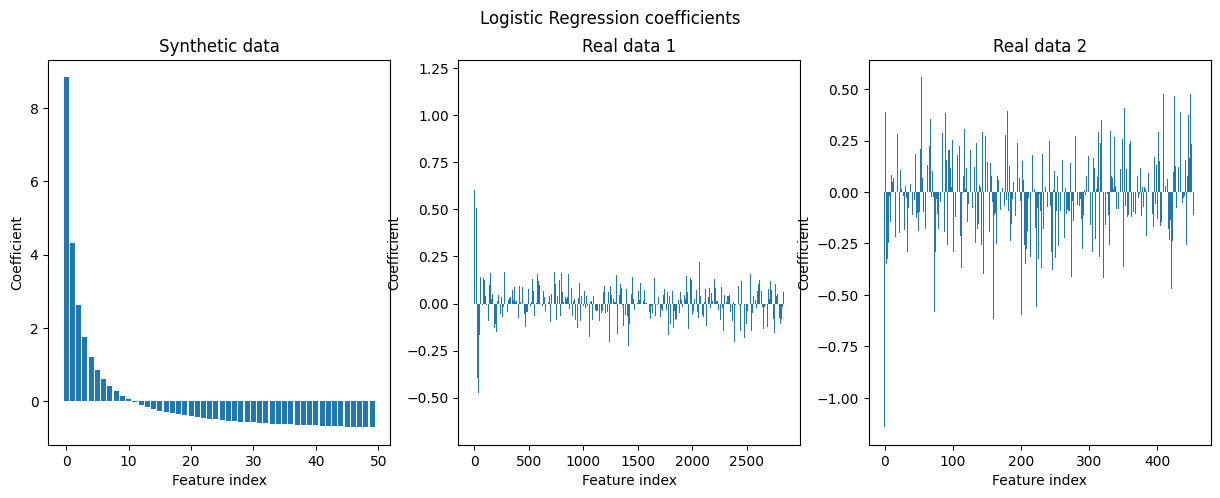

In [25]:
# plot coefficients of regular logistic regression
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].bar(np.arange(len(lr_synthetic.coef_[0])), lr_synthetic.coef_[0])
axs[0].set_title("Synthetic data")
axs[0].set_xlabel("Feature index")
axs[0].set_ylabel("Coefficient")

axs[1].bar(np.arange(len(lr_real1.coef_[0])), lr_real1.coef_[0])
axs[1].set_title("Real data 1")
axs[1].set_xlabel("Feature index")
axs[1].set_ylabel("Coefficient")

axs[2].bar(np.arange(len(lr_real2.coef_[0])), lr_real2.coef_[0])
axs[2].set_title("Real data 2")
axs[2].set_xlabel("Feature index")
axs[2].set_ylabel("Coefficient")

fig.suptitle("Logistic Regression coefficients")
plt.show()

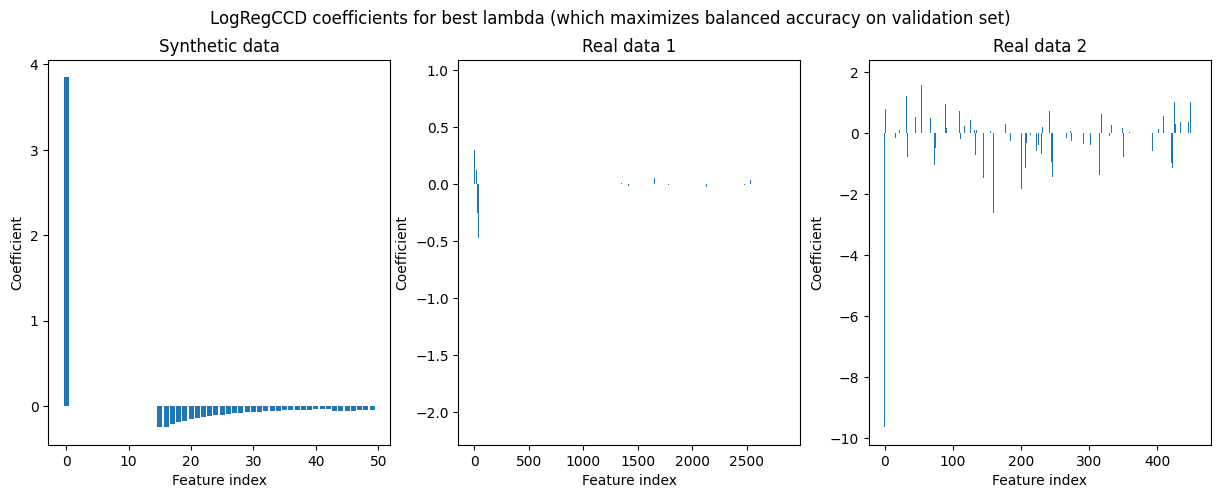

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].bar(np.arange(len(ccd_synthetic.best_beta)), ccd_synthetic.best_beta)
axs[0].set_title("Synthetic data")
axs[0].set_xlabel("Feature index")
axs[0].set_ylabel("Coefficient")

axs[1].bar(np.arange(len(ccd_real1.best_beta)), ccd_real1.best_beta)
axs[1].set_title("Real data 1")
axs[1].set_xlabel("Feature index")
axs[1].set_ylabel("Coefficient")

axs[2].bar(np.arange(len(ccd_real2.best_beta)), ccd_real2.best_beta)
axs[2].set_title("Real data 2")
axs[2].set_xlabel("Feature index")
axs[2].set_ylabel("Coefficient")

fig.suptitle(
    "LogRegCCD coefficients for best lambda (which maximizes balanced accuracy on validation set)"
)
plt.show()

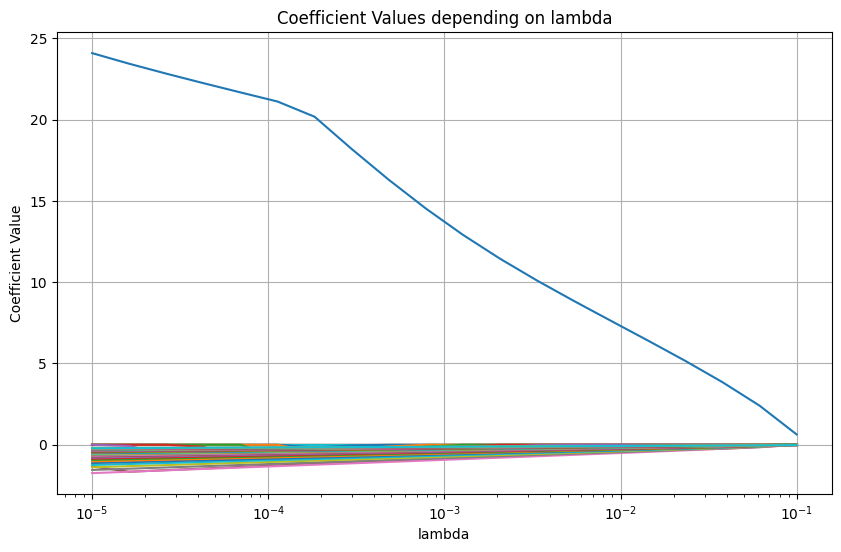

In [ ]:
ccd_synthetic.plot_coefficients()

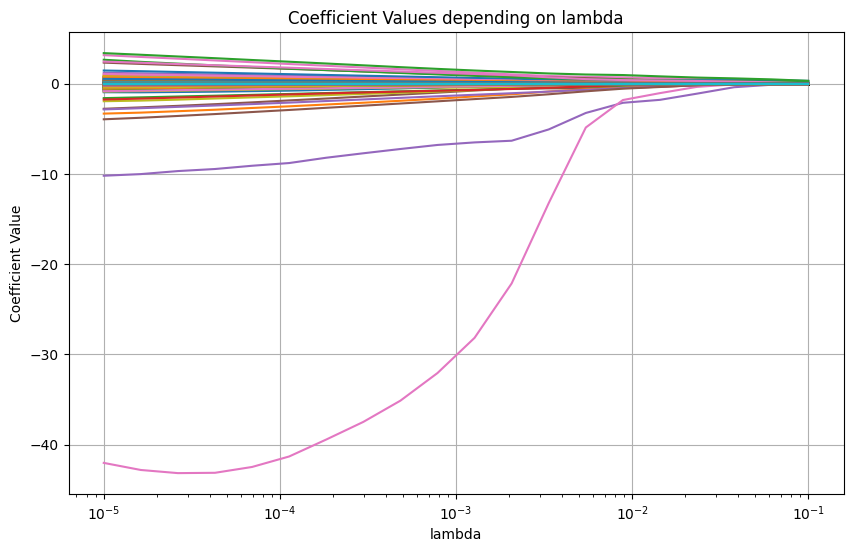

In [ ]:
ccd_real1.plot_coefficients()

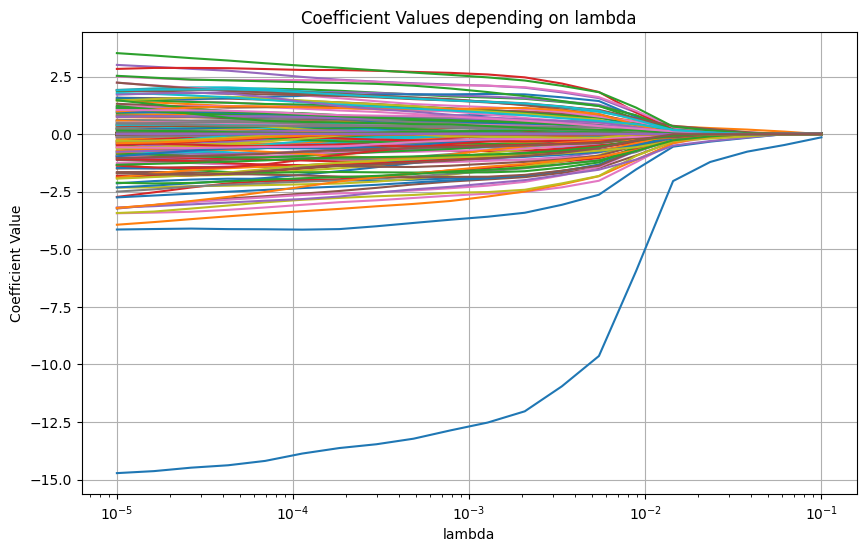

In [ ]:
ccd_real2.plot_coefficients()

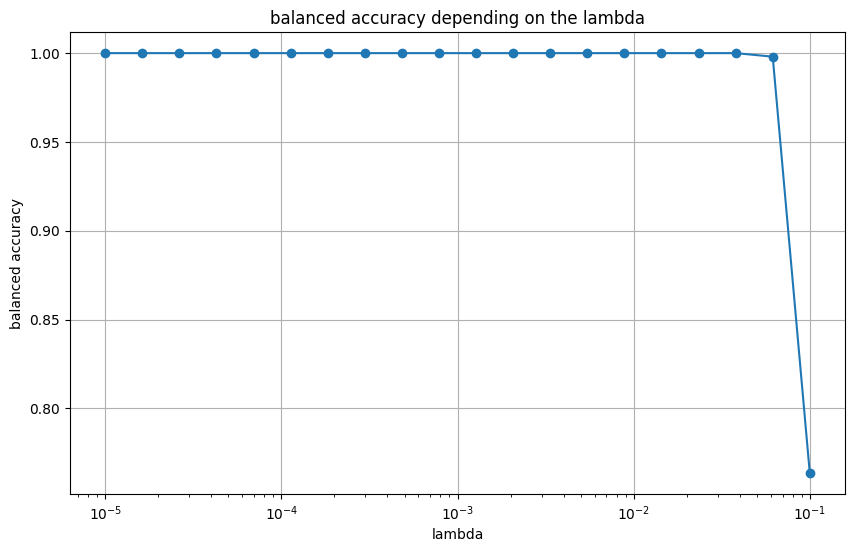

In [29]:
ccd_synthetic.plot("balanced accuracy", val_synthetic_x, val_synthetic_y)

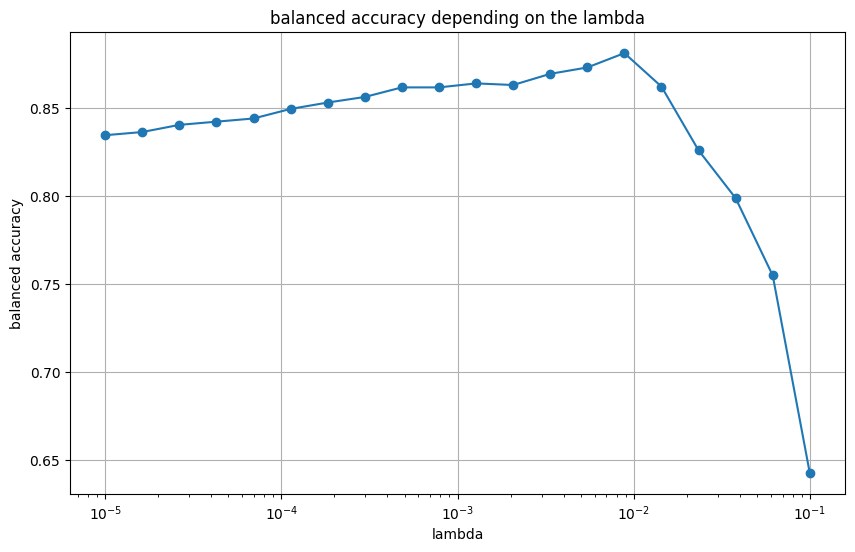

In [30]:
ccd_real1.plot("balanced accuracy", val_real_x1, val_real_y1)

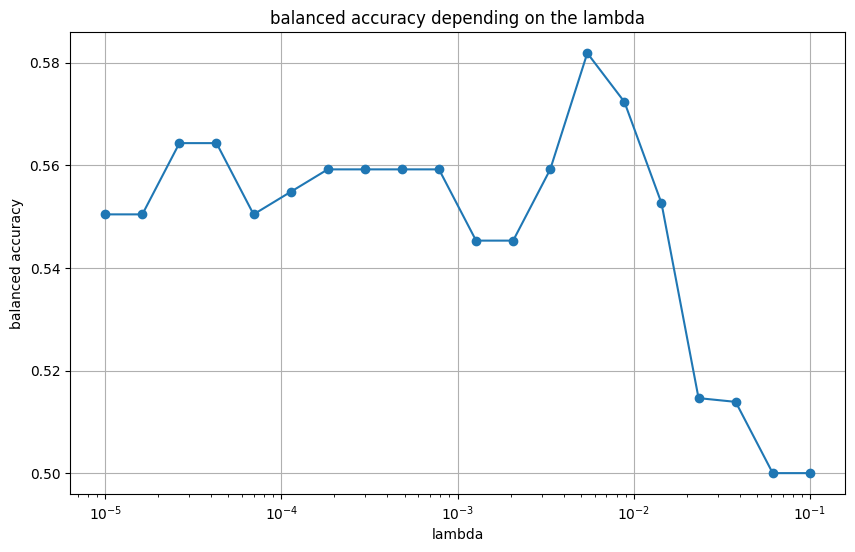

In [31]:
ccd_real2.plot("balanced accuracy", val_real_x2, val_real_y2)